# reading remote data: examples

dataset to use: PP8 ttbar from 2015 CMS Open Data, converted to flat ntuple

In [1]:
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np

dataset_opendata = "http://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root"
treename = "events"
bins = np.linspace(0, 250, 26)

#### using `uproot`

[[96.6, 90.3, 66.4, 57.2, 35.4, 16.4, 16.1, ... 16, 14.9, 13.9, 13.6, 10.4, 10.1]]


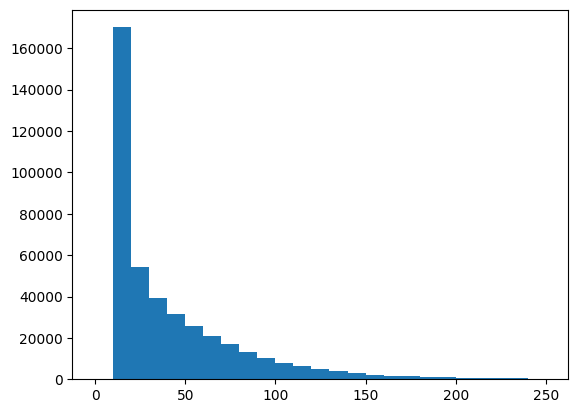

In [2]:
import uproot

f = uproot.open(dataset_opendata)
jet_pt = f[treename]["jet_pt"].array()
print(jet_pt)
plt.hist(ak.flatten(jet_pt), bins=bins);

#### using `func_adl_uproot`

[[96.6, 90.3, 66.4, 57.2, 35.4, 16.4, 16.1, ... 16, 14.9, 13.9, 13.6, 10.4, 10.1]]


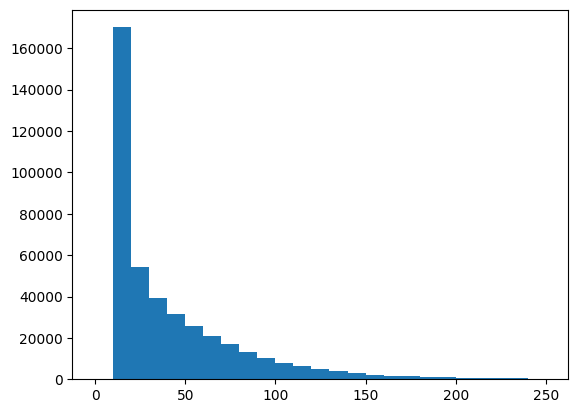

In [3]:
from func_adl_uproot import UprootDataset

ds = UprootDataset(dataset_opendata, treename)
jet_pt_query = ds.Select(lambda event: event.jet_pt)
jet_pt = jet_pt_query.value()
print(jet_pt)
plt.hist(ak.flatten(jet_pt), bins=bins);

#### using `func_adl_servicex`

querying e.g. https://uproot-atlas.servicex.af.uchicago.edu/

http://xrootd-local....:   0%|     | 0/9000000000.0 [00:00]

        http://xrootd-local.... Downloaded:   0%| | 0/90000

[[96.6, 90.3, 66.4, 57.2, 35.4, 16.4, 16.1, ... 16, 14.9, 13.9, 13.6, 10.4, 10.1]]


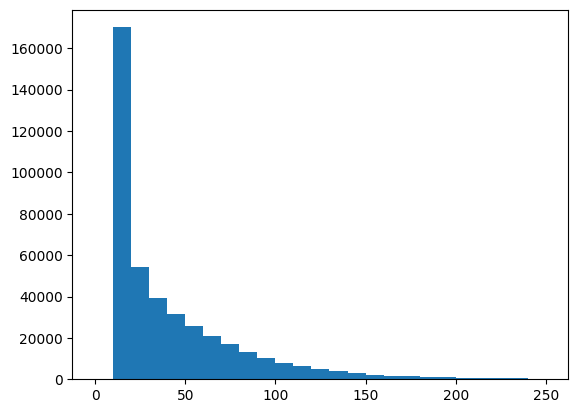

In [4]:
from servicex import ServiceXDataset
from func_adl_servicex import ServiceXSourceUpROOT

sx_dataset = ServiceXDataset(dataset_opendata, backend_name='uproot', ignore_cache=False)
ds = ServiceXSourceUpROOT(sx_dataset, treename)
jet_pt_query = ds.Select(lambda event: event.jet_pt)

jet_pt = jet_pt_query.AsAwkwardArray().value()
print(jet_pt)
plt.hist(ak.flatten(jet_pt), bins=bins);

#### Streaming data from ROOT files

In [5]:
import urllib

from servicex import ServiceXDataset
import uproot

dummy_ds = ServiceXSourceUpROOT("cernopendata://dummy", "Events", backend_name="uproot")
dummy_ds.return_qastle = True
query = dummy_ds.Select(lambda e: {"event": e.event, "el_pt": e.Electron_pt}).value()

dataset_name = ["https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/nanoaod15.root"]
sx_dataset = ServiceXDataset(dataset_name, backend_name='uproot', ignore_cache=False)

transformed_files = sx_dataset.get_data_rootfiles_uri(query, as_signed_url=True)

# open remote file
with uproot.open(f"{transformed_files[0].url}:servicex") as f:
    print(f"remote file content: {f.keys()}")

# download file
for i, output in enumerate(transformed_files):
    output_fname = f"{i}.root"
    print(f"downloading {output_fname}")
    urllib.request.urlretrieve(output.url, filename=output_fname)

# open local file
with uproot.open("0.root:servicex") as f:
    print(f"local file content: {f.keys()}")

[https://xrootd-loca...:   0%|     | 0/9000000000.0 [00:00]

remote file content: ['event', 'nel_pt', 'el_pt']
downloading 0.root
local file content: ['event', 'nel_pt', 'el_pt']


#### xAOD backend

taken from https://github.com/iris-hep/func_adl_servicex#using-the-xaod-backend

In [ ]:
from func_adl_servicex import ServiceXSourceXAOD

dataset_xaod = "mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00"
ds = ServiceXSourceXAOD(dataset_xaod)
data = (
    ds
    .SelectMany('lambda e: (e.Jets("AntiKt4EMTopoJets"))')
    .Where('lambda j: (j.pt()/1000)>30')
    .Select('lambda j: j.pt()')
    .AsAwkwardArray(["JetPt"])
    .value()
)

print(data['JetPt'])